# Geopricing with atoti
In this notebook we will explore a pricing use case that combines machine learning algorithms and atoti.  
We will start by creating clusters of stores depending on their local competition and current prices, then simulate various pricing strategies with atoti.

### Dependencies
A few libraries will need to be installed for this notebook to work:  
- conda install folium scipy scikit-learn matplotlib seaborn 

In [1]:
# import sys

# !conda install --yes --prefix {sys.prefix} folium scipy scikit-learn matplotlib seaborn

In [2]:
import atoti as tt
import pandas as pd

Welcome to atoti 0.4.1!

By using this community edition, you agree with the license available at https://www.atoti.io/eula.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


## Computing stores features

### 1. Counting the number of competitor stores
We will first start by loading our stores.

In [3]:
stores_df = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/stores.csv", sep=";"
)
stores_df.head(5)

,StoreId,StoreName,Adress,ZipCode,City,Country,Latitude,Longitude,Company
0,1,ActiveViam Store Paris 1er,Paris 1er,75001,Paris,France,48.860757,2.342566,ActiveViam
1,2,ActiveViam Store Paris 15,Paris 15,75015,Paris,France,48.840412,2.312649,ActiveViam
2,3,ActiveViam Store Paris 18,Paris 18,75018,Paris,France,48.886483,2.344326,ActiveViam
3,4,ActiveViam Store Paris 12,Paris 12,75012,Paris,France,48.832182,2.375729,ActiveViam
4,5,ActiveViam Store Paris 16,Paris 16,75016,Paris,France,48.855454,2.280886,ActiveViam


And then those of the competitors.

In [4]:
competitor_stores_df = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/competitor_stores.csv", sep=";"
)
competitor_stores_df.head(5)

,CompetitorStoreId,CompetitorStoreName,CompetitorStoreAdress,CompetitorStoreZipCode,CompetitorStoreCity,CompetitorStoreCountry,CompetitorStoreLatitude,CompetitorStoreLongitude,CompetitorStoreCompany
0,101,Concurrent Premium,Paris 1er,75001,Paris,France,48.860757,2.342566,Concurrent Premium
1,102,Concurrent Premium,Paris 15,75015,Paris,France,48.840412,2.312649,Concurrent Premium
2,103,Concurrent Premium,Paris 18,75018,Paris,France,48.886483,2.344326,Concurrent Premium
3,104,Concurrent Premium,Paris 12,75012,Paris,France,48.832182,2.375729,Concurrent Premium
4,105,Concurrent Premium,Paris 16,75016,Paris,France,48.855454,2.280886,Concurrent Premium


We can already visualize on a map our stores (in red) and those of the competition (in blue).

In [5]:
from utils import geo_utils

In [6]:
stores_map = geo_utils.build_stores_map(competitor_stores_df, stores_df)
stores_map

To assess whether a store has strong competition or not, we will count how many competitor stores there are in an area of 1kms, 5kms, 10kms and 20kms.  
In order to to that, we first need to compute distances between stores then count the number of competitor stores for each of the kilometers values above.

### Computing distances between stores
To compute distances between stores, we simply used the [harvesine formula](https://en.wikipedia.org/wiki/Haversine_formula). Note that another approach would be to use instead something like the [google API to compute distances and durations between two points](https://developers.google.com/maps/documentation/distance-matrix/intro) (thus taking into accounts possible means of transportation).

First we build a matrix containing the distances between stores and all competitors.

In [7]:
stores_distances_matrix = geo_utils.create_stores_distances_matrix(
    stores_df, competitor_stores_df
)

stores_distances_matrix.head()

,CompetitorStoreId,StoreId,Competitor distance KM
0,101,1,0.000000
1,101,2,3.145965
2,101,3,2.861697
3,101,4,3.995581
4,101,5,4.547896


And we will use atoti to compute the number of competitors per area.

In [8]:
session = tt.create_session()

In [9]:
# distances_matrix = session.read_pandas(
#     stores_distances_matrix,
#     keys=["StoreId", "CompetitorStoreId"],
#     store_name="Distances to competitor stores",
# )

In [10]:
# distances_cube = session.create_cube(distances_matrix, "Distances cube")

In [11]:
# m = distances_cube.measures
# lvl = distances_cube.levels

In [12]:
# m["Competitors_1_KM"] = tt.agg.sum(
#     tt.where((m["Competitor distance KM.SUM"] < 1), m["contributors.COUNT"], 0),
#     scope=tt.scope.origin(lvl["StoreId"], lvl["CompetitorStoreId"]),
# )

# m["Competitors_5_KM"] = tt.agg.sum(
#     tt.where((m["Competitor distance KM.SUM"] < 5), m["contributors.COUNT"], 0),
#     scope=tt.scope.origin(lvl["StoreId"], lvl["CompetitorStoreId"]),
# )

# m["Competitors_10_KM"] = tt.agg.sum(
#     tt.where((m["Competitor distance KM.SUM"] < 10), m["contributors.COUNT"], 0),
#     scope=tt.scope.origin(lvl["StoreId"], lvl["CompetitorStoreId"]),
# )

# m["Competitors_20_KM"] = tt.agg.sum(
#     tt.where((m["Competitor distance KM.SUM"] < 20), m["contributors.COUNT"], 0),
#     scope=tt.scope.origin(lvl["StoreId"], lvl["CompetitorStoreId"]),
# )

We will then use an atoti query to generate a pandas dataframe that contains the number of competitors in each area (columns) against the stores (rows).  
In the later section, we will see how this dataframe is used as inputs for machine learning.

In [13]:
# stores_competitors_count_per_area = distances_cube.query(
#     m["Competitors_1_KM"],
#     m["Competitors_5_KM"],
#     m["Competitors_10_KM"],
#     m["Competitors_20_KM"],
#     levels=[lvl["StoreId"], lvl["StoreName"]],
# )
# stores_competitors_count_per_area.head()

### 2. Computing the price index per store

There are different existing formulas for the price index but the idea behind is always the same: the price index is a measurement of where a retailer is positioned compared to one or multiple of its competitors.

The formula we will use in this example compares a product price to the average price found among the local competitors of a particular store, measuring at which percentage of this average competitors price the product is.

We will weight the price index indicator by the margin when aggregating above store and product level. This is so that we can later optimize the price index for products that contribute the most to the margin.  
Other commonly used formulas weight by sales quantity or revenue.

#### Price index formula:

# $100 \times \frac{\sum_{s,p \in (Stores,Products)}\frac{Selling Price(s,p)}{Average Competitor Price(s,p)} \times Margin(s,p)}{\sum_{s,p \in (Stores,Products)}Margin(s,p)}$

Normally, we can have the selling price, cost price and quantity of the product sold. Margin hence can be derived, and we can consequently see the impact on margin when price index changes.  
In this notebook however, we simplify the use case by having only the SellingPrice and the total Margin for each product by stores as required by the above formula.

In [14]:
#  We used pandas to read the selling price here as we will be using it again for price optimisation in the later section.
product_sales_df = pd.read_csv("product_sales.csv")

# types = {"ProductId": tt.types.INT, "StoreId": tt.types.INT}
productSales = session.read_pandas(
    product_sales_df,
    keys=["ProductId", "StoreId"],
    store_name="ProductSales",
    types={"ProductId": tt.types.INT, "StoreId": tt.types.INT},
)

productSales.head()

The store has been sampled because there are more than 10000 lines in the files to load. Call Session.load_all_data() to trigger the full load of the data.


SellingPrice    Margin
ProductId StoreId                        
4096.0    1.0             1.920  1959.530
          2.0             2.068  2204.228
          3.0             1.820  1835.545
          4.0             1.825  1641.052
          5.0             2.016  1307.136

We will also require the competitors' product pricing against our stores.  
Due to the amount of data in this store, the store will be sampled by default. We will proceed to load all the data after we are done modeling the cube.

In [15]:
competitorPrices = session.read_csv(
    "competitor_prices.csv",
    keys=["ProductId", "CompetitorStoreId", "StoreId"],
    store_name="CompetitorPrices",
    #     types={
    #         "ProductId": tt.types.INT,
    #         "StoreId": tt.types.INT,
    #         "CompetitorStoreId": tt.types.INT,
    #     }
)

competitorPrices.head()

,,,CompetitorPrice
ProductId,CompetitorStoreId,StoreId,
4096.0,101.0,1.0,2.287
4097.0,101.0,1.0,2.320
4098.0,101.0,1.0,2.519
4099.0,101.0,1.0,2.504
4100.0,101.0,1.0,3.309


We load the dataframe _distance_matrix_ that we derive in the earlier section into a store.  
This will allow us to perform price index analysis against the competitors within a distance range.

In [16]:
distance_matrix = session.read_pandas(
    stores_distances_matrix,
    keys=["StoreId", "CompetitorStoreId"],
    store_name="DistanceMatrix",
    types={"StoreId": tt.types.INT, "CompetitorStoreId": tt.types.INT,},
)

distance_matrix.head()

,,Competitor distance KM
StoreId,CompetitorStoreId,
1.0,101.0,0.000000
2.0,101.0,3.145965
3.0,101.0,2.861697
4.0,101.0,3.995581
5.0,101.0,4.547896


We have the key stores necessary for us to generate the data required for machine learning.  
However, we will also load the follow stores that will allow us to have more in-depth analysis:
- Products: Product catalogue
- Stores: Store information such as location
- CompetitorsStores: Competitors' store information

In [17]:
products = session.read_csv(
    "s3://data.atoti.io/notebooks/geopricing/products_info.csv",
    sep=";",
    keys=["ProductId"],
    store_name="Products",
)

products.head()

,EAN,ProductName,Brand,Size,Unit,Department,SubDepartment,Category,SubCategory
ProductId,,,,,,,,,
4096,3124480000378,"1,5L CANADA DRY PET",CANADA DRY,1.5,L,LIQUIDES,SOFT TRADITIONNELS,TONIC,GINGER ALE
4097,3124480183927,"1,5L SCHWEPPES LEMON PET",SCHWEPPES,1.5,L,LIQUIDES,SOFT TRADITIONNELS,BOISSON AUX FRUITS GAZEUX,PET - PVC
4098,3124480183811,2L OASIS ORANGE PET,OASIS,2,L,LIQUIDES,SOFT TRADITIONNELS,BOISSON AUX FRUITS PLAT,PET - PVC
4099,3124480183828,2L OASIS TROPICAL PET,OASIS,2,L,LIQUIDES,SOFT TRADITIONNELS,BOISSON AUX FRUITS PLAT,PET - PVC
4100,3124480186577,6X33CL OASIS TROPICAL BT,OASIS,6x33,cl,LIQUIDES,SOFT TRADITIONNELS,BOISSON AUX FRUITS PLAT,BOITES


In [18]:
stores = session.read_csv(
    "s3://data.atoti.io/notebooks/geopricing/stores.csv",
    sep=";",
    keys=["StoreId"],
    store_name="Stores",
)

stores.head()

,StoreName,Adress,ZipCode,City,Country,Latitude,Longitude,Company
StoreId,,,,,,,,
1,ActiveViam Store Paris 1er,Paris 1er,75001,Paris,France,48.860757,2.342566,ActiveViam
2,ActiveViam Store Paris 15,Paris 15,75015,Paris,France,48.840412,2.312649,ActiveViam
3,ActiveViam Store Paris 18,Paris 18,75018,Paris,France,48.886483,2.344326,ActiveViam
4,ActiveViam Store Paris 12,Paris 12,75012,Paris,France,48.832182,2.375729,ActiveViam
5,ActiveViam Store Paris 16,Paris 16,75016,Paris,France,48.855454,2.280886,ActiveViam


In [19]:
competitorStore = session.read_csv(
    "s3://data.atoti.io/notebooks/geopricing/competitor_stores.csv",
    sep=";",
    keys=["CompetitorStoreId"],
    store_name="CompetitorsStores",
)

competitorStore.head()

,CompetitorStoreName,CompetitorStoreAdress,CompetitorStoreZipCode,CompetitorStoreCity,CompetitorStoreCountry,CompetitorStoreLatitude,CompetitorStoreLongitude,CompetitorStoreCompany
CompetitorStoreId,,,,,,,,
101,Concurrent Premium,Paris 1er,75001,Paris,France,48.860757,2.342566,Concurrent Premium
102,Concurrent Premium,Paris 15,75015,Paris,France,48.840412,2.312649,Concurrent Premium
103,Concurrent Premium,Paris 18,75018,Paris,France,48.886483,2.344326,Concurrent Premium
104,Concurrent Premium,Paris 12,75012,Paris,France,48.832182,2.375729,Concurrent Premium
105,Concurrent Premium,Paris 16,75016,Paris,France,48.855454,2.280886,Concurrent Premium


_ProductSales_ will be our base store as we want to be able to see all the products available in our stores.  
Competitors may or may not have the same products as our product catalogue. We are only interested in the products that we are also selling.  
Hence we will join the _CompetitorPrices_ store to our _ProductSales_ store by _ProductId_ and _StoreId_.

In [20]:
productSales.join(
    competitorPrices, mapping={"ProductId": "ProductId", "StoreId": "StoreId"}
)

To have more efficient joins, we join the _Products_ and _Stores_ to the base store since this is the most direct reference. 

In [21]:
productSales.join(products, mapping={"ProductId": "ProductId"})
productSales.join(stores, mapping={"StoreId": "StoreId"})

As _CompetitorPrices_ store is more granular than the _CompetitorStore_, we join the latter to _CompetitorPrices_.

In [22]:
competitorPrices.join(
    competitorStore, mapping={"CompetitorStoreId": "CompetitorStoreId"}
)

_DistanceMatrix_ contains both the _StoreId_ and _CompetitorStoreId_.  \
As _CompetitorPrices_ store is already joined to the _ProductSales_ store which contains the _StoreId_.  \
By joining _DistanceMatrix_ to the _CompetitorPrices_, the _DistanceMatrix_ store automatically get linked to the _ProductSales_ store.

In [23]:
competitorPrices.join(
    distance_matrix,
    mapping={"CompetitorStoreId": "CompetitorStoreId", "StoreId": "StoreId"},
)

# productSales.join(distance_matrix, mapping={"StoreId": "StoreId"})

Let's proceed to create the cube.

In [24]:
price_index_cube = session.create_cube(productSales, "CompetitorPricesCube")

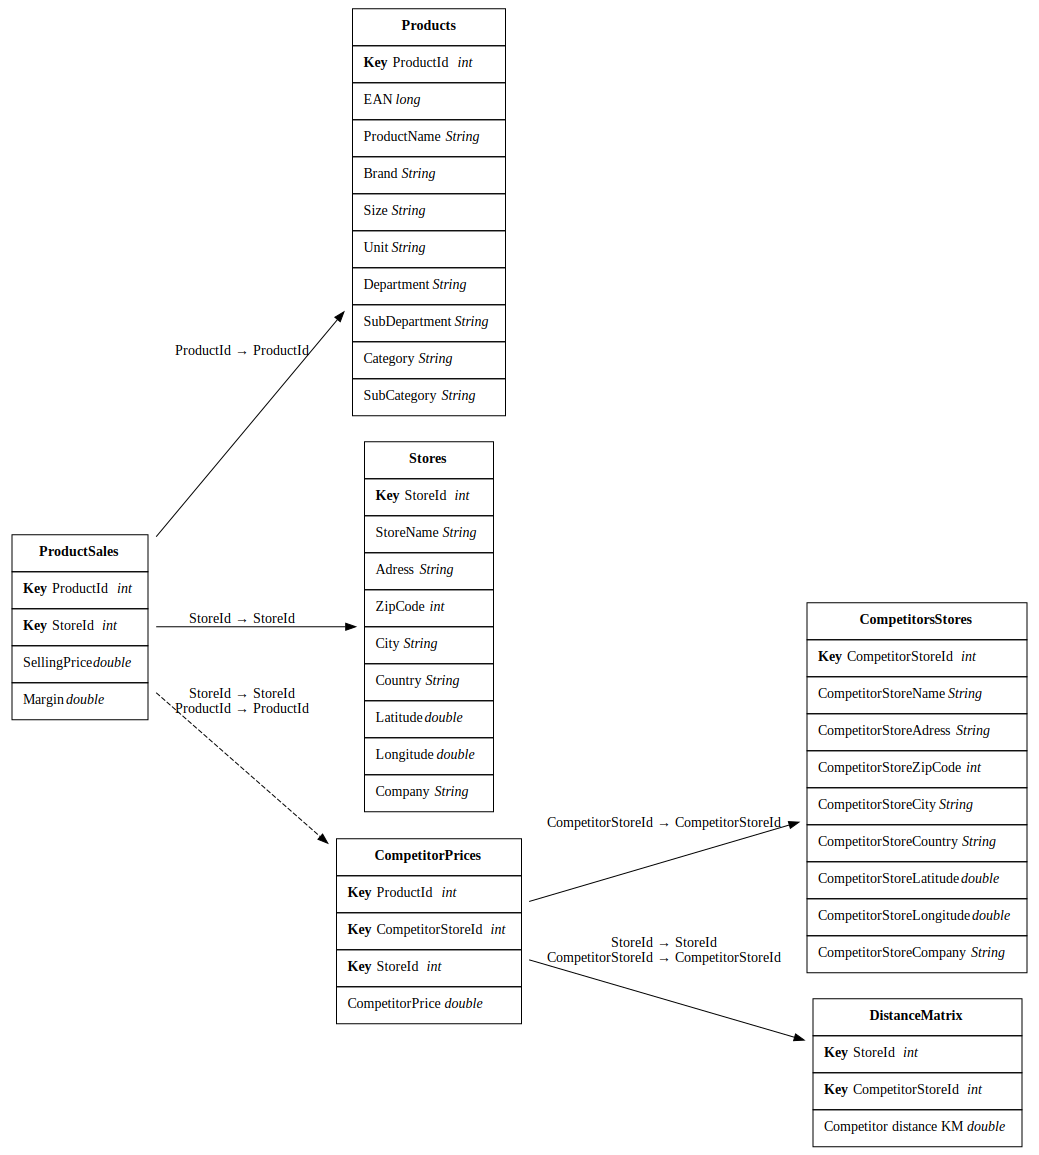

In [25]:
price_index_cube.schema

In [26]:
h = price_index_cube.hierarchies
m = price_index_cube.measures
lvl = price_index_cube.levels

m

We can see a _SUM_ and _MEAN_ measure is created columns of type double/float for the base store - _ProductSales_.  \
A _VALUE_ measure is created for columns of type double/float in the other referenced stores.  
Let's create a measure to get the mean of _CompetitorPrice_ which will be used to derive the price index.

In [27]:
m["CompetitorPrice.MEAN"] = tt.agg.mean(competitorPrices["CompetitorPrice"])

We see how the weight price index indicator can be achieved in the next few cells.  
Realize how we are setting the scope on _ProductId_ and _StoreId_? This will ensure the summation of the various measures at the _Store_ and _Product_ level as required by the formula.

# ${\sum_{s,p \in (Stores,Products)}\frac{Selling Price(s,p)}{Average Competitor Price(s,p)} \times Margin(s,p)}$

In [28]:
price_index_numerator = tt.agg.sum(
    (m["SellingPrice.MEAN"] * m["Margin.SUM"]) / m["CompetitorPrice.MEAN"],
    scope=tt.scope.origin(lvl["ProductId"], lvl["StoreId"]),
)

Finally, we calculate the contribution of the product towards the total margin.

In [29]:
m["Price Index"] = price_index_numerator / m["Margin.SUM"]

We can now have the price index per store and product.  
As we are currently in sampling mode, let's trigger full data load to do some visualizations.

In [30]:
session.load_all_data()

Let's visualize the price index per store.

In [32]:
price_index_cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

#### Extracting Price index for Clustering Analysis

We output the price index per store into a pandas dataframe using an atoti query.  
It will be used as the input for machine learning in the next section. 

In [32]:
price_index_per_store = price_index_cube.query(
    m["Price Index"], levels=[lvl["StoreId"], lvl["StoreName"]]
)
price_index_per_store.head()

,,Price Index
StoreId,StoreName,
1,ActiveViam Store Paris 1er,0.986389
2,ActiveViam Store Paris 15,1.043176
3,ActiveViam Store Paris 18,0.960006
4,ActiveViam Store Paris 12,0.969073
5,ActiveViam Store Paris 16,1.030924


### Getting Number of Competitors per Distance Bucket

In [39]:
price_index_cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

In [42]:
m["Nr Competitors"] = tt.agg.count_distinct(competitorPrices["CompetitorStoreId"])

m["Competitors_10_KM"] = tt.agg.mean(
    tt.where((m["Competitor distance KM.VALUE"] < 10),  m["Nr Competitors"], 0),
    scope=tt.scope.origin(lvl["StoreId"], lvl["CompetitorStoreId"]),
)

In [35]:
# m["Competitors_1_KM"] = tt.agg.sum(
#     tt.where(
#         (m["Competitor distance KM.VALUE"] < 1),
#         tt.agg.count_distinct(lvl["CompetitorStoreId"]),
#         0,
#     ),
#     scope=tt.scope.origin(lvl["StoreId"]),
# )

# m["Competitors_5_KM"] = tt.agg.sum(
#     tt.where((m["Competitor distance KM.VALUE"] < 5), m["contributors.COUNT"], 0),
#     scope=tt.scope.origin(lvl["StoreId"], lvl["CompetitorStoreId"]),
# )

# m["Competitors_10_KM"] = tt.agg.sum(
#     tt.where((m["Competitor distance KM.VALUE"] < 10), m["contributors.COUNT"], 0),
#     scope=tt.scope.origin(lvl["StoreId"], lvl["CompetitorStoreId"]),
# )

# m["Competitors_20_KM"] = tt.agg.sum(
#     tt.where((m["Competitor distance KM.VALUE"] < 20), m["contributors.COUNT"], 0),
#     scope=tt.scope.origin(lvl["StoreId"], lvl["CompetitorStoreId"]),
# )

In [43]:
# competitorPrices

Store(_name='CompetitorPrices', _scenario='Base', _columns={'ProductId': Column(name='ProductId', data_type=AtotiType(java_type='int', nullable=True)), 'CompetitorStoreId': Column(name='CompetitorStoreId', data_type=AtotiType(java_type='int', nullable=True)), 'CompetitorPrice': Column(name='CompetitorPrice', data_type=AtotiType(java_type='double', nullable=True)), 'StoreId': Column(name='StoreId', data_type=AtotiType(java_type='int', nullable=True))})

We will then use an atoti query to generate a pandas dataframe that contains the number of competitors in each area (columns) against the stores (rows).  
In the later section, we will see how this dataframe is used as inputs for machine learning.

In [37]:
# stores_competitors_count_per_area = price_index_cube.query(
#     m["Competitors_1_KM"],
#     m["Competitors_5_KM"],
#     m["Competitors_10_KM"],
#     m["Competitors_20_KM"],
#     levels=[lvl["StoreId"], lvl["StoreName"]],
# )
# stores_competitors_count_per_area.head()

,,Competitors_1_KM,Competitors_5_KM,Competitors_10_KM,Competitors_20_KM
StoreId,StoreName,,,,
1,ActiveViam Store Paris 1er,6127,28407,36762,39547
2,ActiveViam Store Paris 15,2785,25622,33977,39547
3,ActiveViam Store Paris 18,2785,20052,39547,39547
4,ActiveViam Store Paris 12,2785,17267,33977,39547
5,ActiveViam Store Paris 16,2785,20052,31192,39547


## Stores clustering using price index and competitors number features

In this part we will use the previously calculated features (nr of competitor stores and price index) to generate 5 clusters of stores.  
Since there are five features (Competitors_1_KM, Competitors_5_KM, Competitors_10_KM, Competitors_20_KM, Price Index), a machine learning algorithm such as k-means is appropriate as the human brain will have too much trouble making clusters that have sense.

In the next section we will use those clusters to generate new prices and assess whether we have managed to improve our pricing.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin

sns.set()  # for plot styling

Merging the features computed in the previous sections:

In [ ]:
price_index_per_store.reset_index(inplace=True)
stores_competitors_count_per_area.reset_index(inplace=True)
price_index_per_store = price_index_per_store.drop(columns=["StoreName"])
stores_competitors_count_per_area = stores_competitors_count_per_area.drop(
    columns=["StoreName"]
)
stores_competitors_count_per_area.StoreId = stores_competitors_count_per_area.StoreId.astype(
    int
)

In [ ]:
price_index_per_store.dtypes

In [ ]:
stores_features = pd.merge(
    stores_competitors_count_per_area,
    price_index_per_store,
    left_on="StoreId",
    right_on="StoreId",
    how="left",
)

Formatting the features for scikit learn

In [ ]:
stores_features = stores_features.set_index("StoreId")
stores_features.head()

Chosing the number of clusters

In [ ]:
number_of_clusters = 5

And running the clustering algorithm

In [ ]:
kmeans = MiniBatchKMeans(number_of_clusters)
kmeans.fit(stores_features)
new_colors = kmeans.cluster_centers_[kmeans.predict(stores_features)]
k_means_labels = pairwise_distances_argmin(stores_features, kmeans.cluster_centers_)
labels = KMeans(number_of_clusters, random_state=0).fit_predict(stores_features)

Using competitors within 1km as an example, we can now analyze the result of the clustering by pair of features using matplotlib as shown below:

In [ ]:
plt.scatter(
    stores_features.loc[:, "Competitors_1_KM"],
    stores_features.loc[:, "Price Index"],
    c=k_means_labels,
    s=50,
    cmap="viridis",
)

plt.xlabel("Nr Competitors within 1km")
plt.ylabel("Price Index")

In the above plot, each color represents a cluster. We can see that clusters seem to be strongly based on the number of competitors rather than on the price index.  
However, to avoid having to plot every couple of features and understand more quickly what our clusters are, we will use seaborn to have a plot of the clustering result for every pair of features.

In [ ]:
stores_features["Cluster"] = labels
stores_features.head(5)

In [ ]:
sns.pairplot(data=stores_features, hue="Cluster")

We can have a better understanding of the clusters with the chart above.  
For example clusters 0 and 4 are those with stores that have a price index close to 1, but the stores in cluster 0 have many more competitors in a 10km radius than those of cluster 4.

Continuing this analysis tells us that:
- Cluster 0 contains stores with an average price index (around 1.0) and a lot of competitor stores around.
- Cluster 1 groups the stores with the fewest number of competitor stores around.
- Cluster 2 contains the stores that have the highest number of competitor stores around them.
- Cluster 3 is in between all other clusters. Stores in this cluster have few competitors in a 5km radius, but a lot in a 20km radius.
- Cluster 4 contains stores with an average price index (around 1.0) but few competitor stores around.


## Pricing Simulations around clusters
We will now generate new prices using the previous clusters in order to take into account the different competitiveness constraints of the stores.  

In [ ]:
from utils import pricer

The below pricing method tries to reduce the prices if the competitiveness is strong, and on the contrary increase it if there is few competition.  
It is directly using the clusters generated from the previous part.

In [ ]:
selling_prices_based_on_clusters = pricer.optimize_prices(
    product_sales_df, stores_features
)

Thanks to atoti built-in simulations capabilities, we can easily create a new scenario for the new pricing by directly loading the price-optimised dataframe.  
All the previously defined KPIs, e.g. the price index, will be re-computed on the fly, enabling us to compare the scenarios and their benefits.

In [ ]:
productSales.scenarios["Selling prices based on clusters"].load_pandas(
    selling_prices_based_on_clusters
)

In [ ]:
price_index_cube.visualize()

Let's load the cluster results obtained from the machine learning model into the cube.

In [ ]:
clusters_df = stores_features[["Cluster"]].reset_index()
clusters_df.StoreId = clusters_df.StoreId.astype("int32")
cluster_store = session.read_pandas(
    clusters_df, keys=["StoreId"], store_name="Clusters"
)

cluster_store.head(10)

In [ ]:
stores.join(cluster_store)

With the cluster information added to the cube, we can now visualize the changes in price index for the 5 clusters.

In [ ]:
price_index_cube.visualize("Price index optimisation difference")

We can see that the pricing method decreased the price index of stores in clusters that have high competition in order for them to attract more customers.  
On the contrary it increased the prices in stores belonging to low competition clusters in order to maximize margin.